# Sales Channel Prediction Case Study

When a company enters a market, the distribution strategy and channel it uses are keys to its success in the market, as well as market know-how and customer knowledge and understanding. Because an effective distribution strategy under efficient supply-chain management opens doors for attaining competitive advantage and strong brand equity in the market, it is a component of the marketing mix that cannot be ignored .

The distribution strategy and the channel design have to be right the first time. The case study of Sales channel includes the detailed study of TV, radio and newspaper channel. The predict the total sales generated from all the sales channel.

In [1]:
#Import Necessary Libraries.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import regression models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

In [3]:
#Import Evaluation metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [4]:
df = pd.read_csv('Advertising.csv')
df.head()

,Unnamed: 0,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


# Feature Description:

Unnamed:0 - does not contribute in sales will remove it.

TV - It refers to the sales count generated from TV advertisement.

Radio - Here radio refers to the sale count generated from radio advertisement.

Newspaper - Newspaper column shows the sales count generated from newpaper sales.

Sales - Sales column refers to the total sales of TV, radio and newspaper.

In [5]:
df = df.drop(columns = 'Unnamed: 0')
df.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


# Observations :

All features are in numerical value.

As per the problem statement I'll have to predict the sales hence 'Sales' is my target variable and rest all the features are my independent variable.

In [6]:
df.shape

(200, 4)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   radio      200 non-null    float64
 2   newspaper  200 non-null    float64
 3   sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [8]:
df.isnull().sum()

TV           0
radio        0
newspaper    0
sales        0
dtype: int64

In [9]:
df.describe()

,TV,radio,newspaper,sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


# In this dataset there are 200 raws and 4 columns, no object data only float and no null values are present in the dataset.

# Data Visualization

# Bar plot to analyse Sales vs TV.

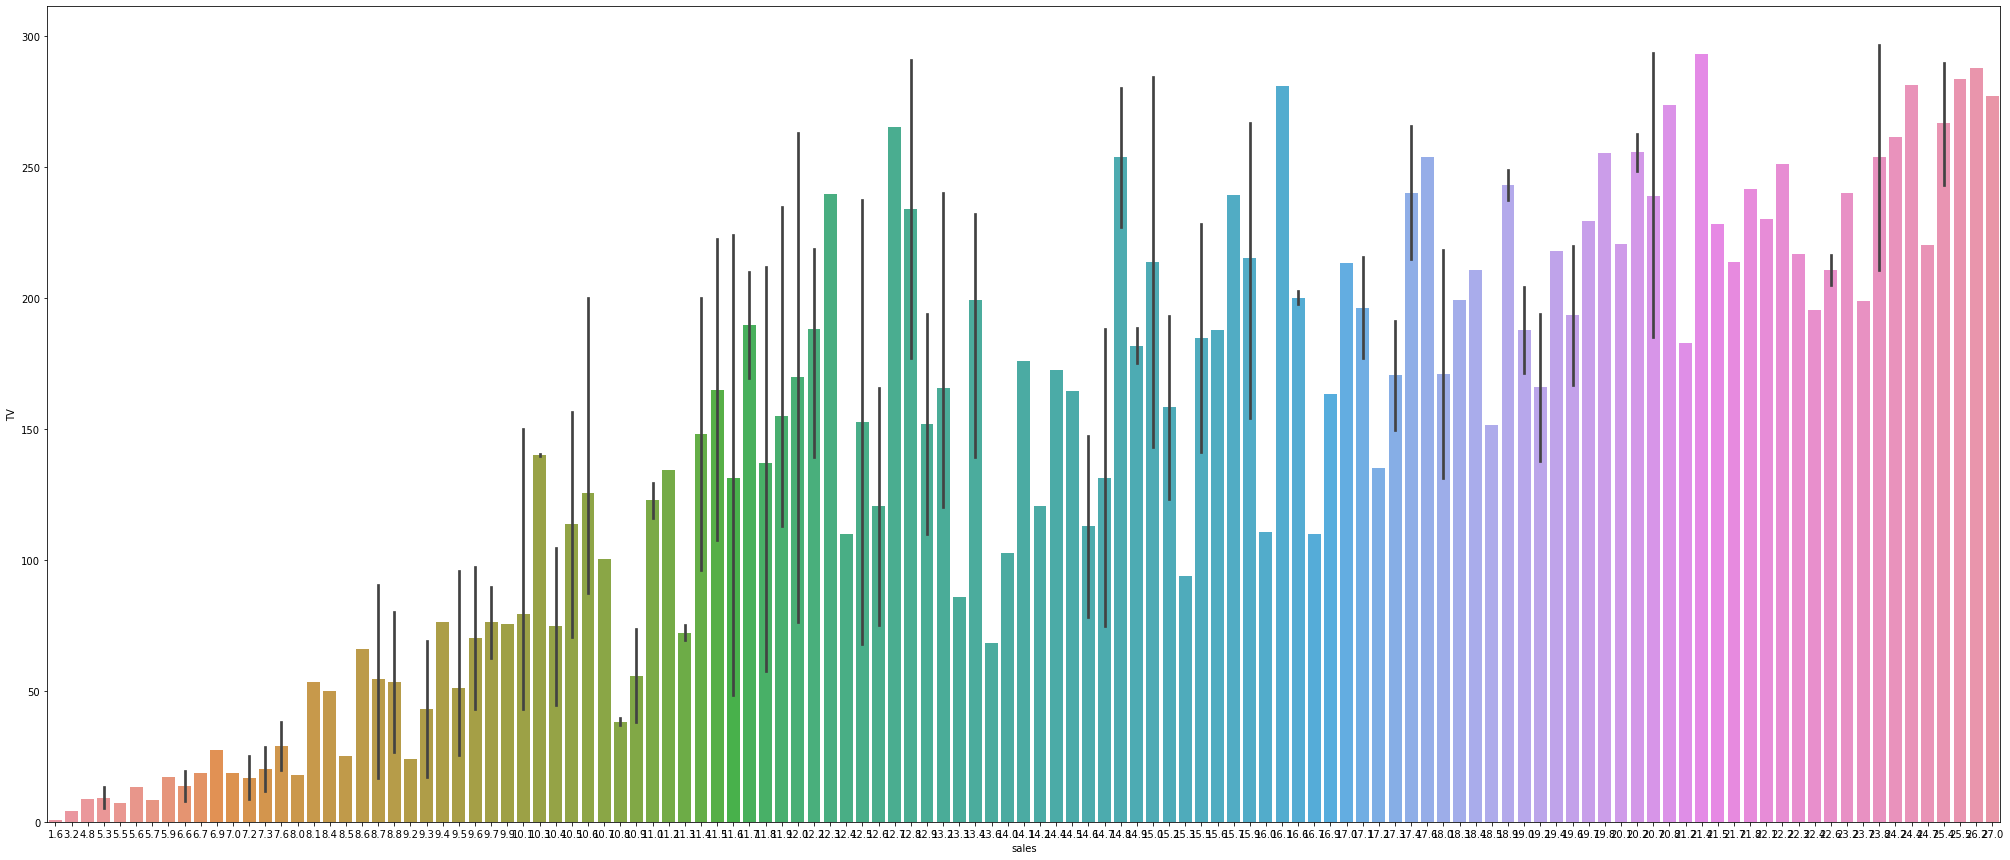

In [10]:
plt.figure(figsize = (35,15))
sns.barplot(x = 'sales', y = 'TV', data = df, palette = None )
plt.show()


There is a strong relationship between TV and Sales, Sales are increasing because of TV advertisement.

# scatter plot to observe the relationship between Radio and Sales.

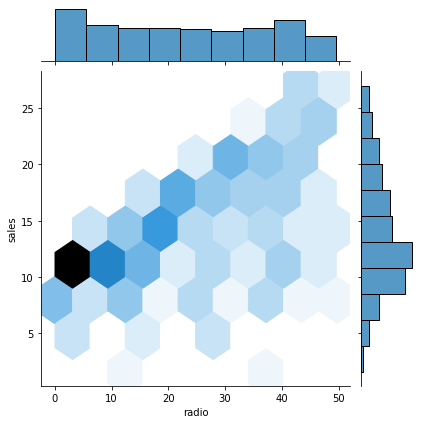

In [11]:
sns.jointplot(x ='radio', y ='sales', data = df, kind ='hex')# KDE shows the density where the points match up the most
plt.show()


There a good enough relationship between radio and sales,but not as strong as with TV ,certain trend is visible.

# Relationship between newspaper and sales

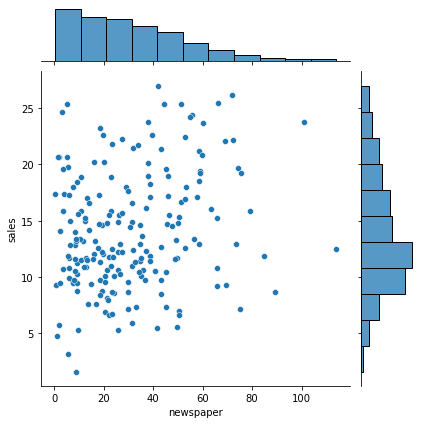

In [12]:
sns.jointplot(x ='newspaper', y ='sales', data = df)
plt.show()


There is no trend visible in the above scatter plot, nwespaper advertisements are not helping the sales.

<Figure size 1152x720 with 0 Axes>

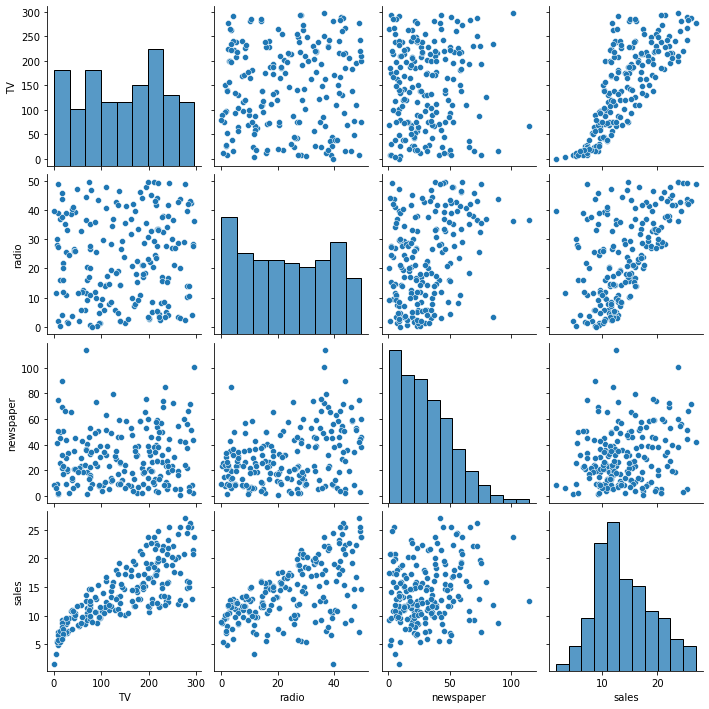

In [13]:
plt.figure(figsize = (16,10))
sns.pairplot(df)
plt.show()

The above pair plot shows apart from newspaper rest two features have good relationship with sales.

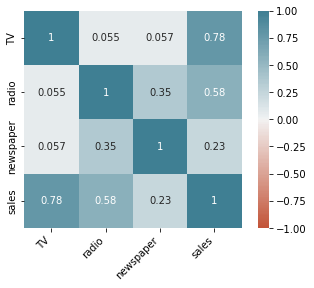

In [14]:
corr = df.corr()
ax = sns.heatmap(
    corr,
    annot = True,
    vmin = -1, vmax = 1, center = 0,
    cmap = sns.diverging_palette(20, 220, n = 200),
    square = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right'
);

TV has strong relationship with Sales.

Radio has good relationship with Sales and newspaper.

Newspaper and sales relationship is okay not as storng as TV and Radio.

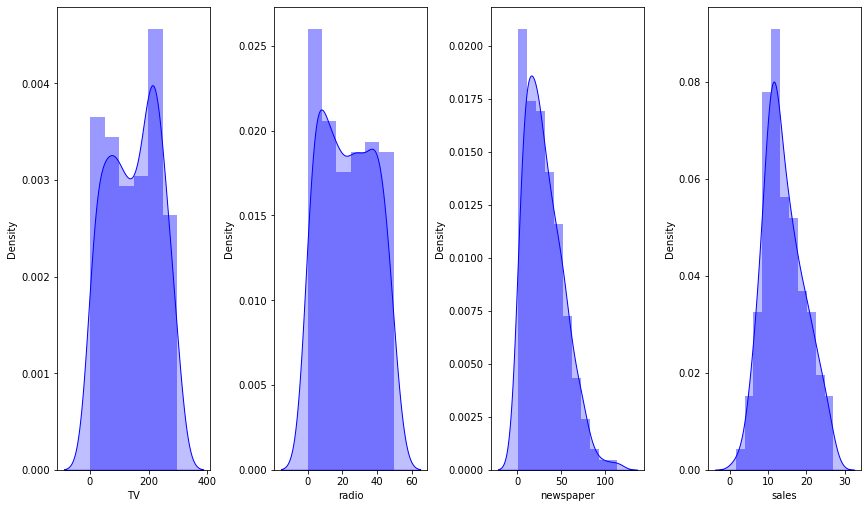

In [15]:
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(12,7))
index = 0
ax = ax.flatten()
for col, value in df.items():
    sns.distplot(value, ax = ax[index], hist = True, color = "b", kde_kws = {"shade": True})
    index += 1
plt.tight_layout(pad = 0.5, w_pad = 0.7, h_pad = 5.0)
plt.show()

Distribution looks good for all the features. However seeing some skewness in newpaper. Data looks pretty clean next will check for outliers.

# check for outliers using box plot

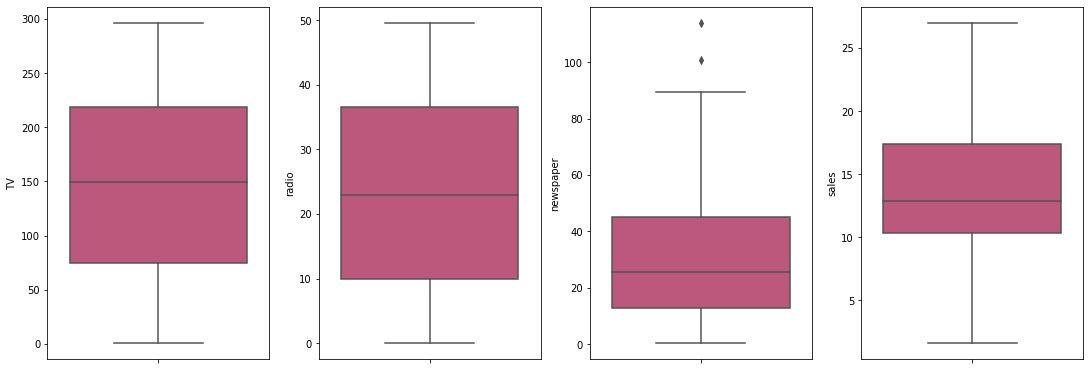

In [16]:
fig, ax = plt.subplots(ncols = 4, nrows = 1, figsize = (15,5))
index = 0
ax = ax.flatten()

for col, value in df.items():
    sns.boxplot(y = col, data = df, ax = ax[index], palette = "plasma")
    index += 1

plt.tight_layout(pad = 0.2, w_pad = 0.9, h_pad = 5.0)
plt.show()

All the features looks good excluding newspaper. In newspaper there are some outliers are present on the higher side, Inter Quantile Range method will be used to identify those outliers and then will remove them.

In [17]:
def remove_outliers_newspaper(df):
    IQR = df['newspaper'].quantile(0.75) - df['newspaper'].quantile(0.25)
    
    higher_range = df['newspaper'].quantile(0.75) + (1.5 * IQR)
    
    df.loc[df['newspaper'] >= higher_range, 'newspaper'] = higher_range

In [18]:
remove_outliers_newspaper(df)

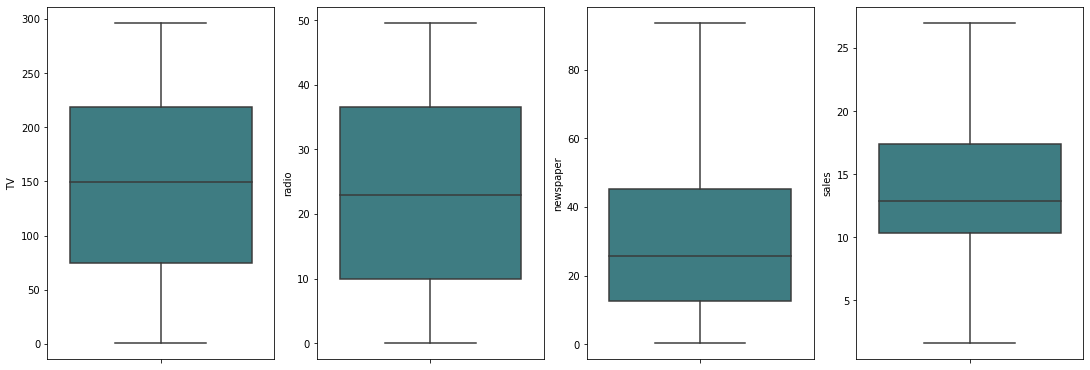

In [19]:
#box plot again to check if outliers have been removed.

fig, ax = plt.subplots(ncols = 4, nrows = 1, figsize = (15,5))
index = 0
ax = ax.flatten()

for col, value in df.items():
    sns.boxplot(y = col, data = df, ax = ax[index], palette = "crest")
    index += 1

plt.tight_layout(pad = 0.2, w_pad = 0.9, h_pad = 5.0)
plt.show()


Outliers have been removed successfully, have to check distribution again.

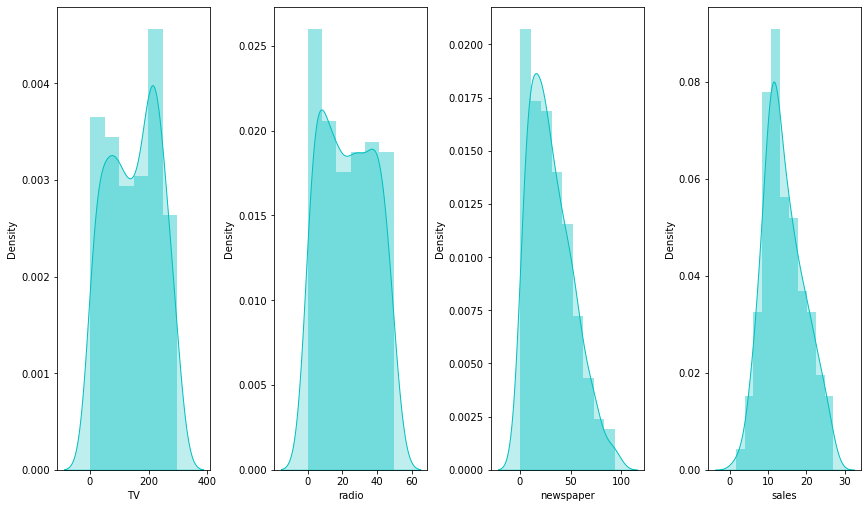

In [20]:
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(12,7))
index = 0
ax = ax.flatten()
for col, value in df.items():
    sns.distplot(value, ax = ax[index], hist = True, color = "c", kde_kws = {"shade": True})
    index += 1
plt.tight_layout(pad = 0.5, w_pad = 0.7, h_pad = 5.0)
plt.show()


In [21]:
x = df.drop(columns = 'sales')
y = df['sales']
x.head()

,TV,radio,newspaper
0,230.1,37.8,69.2
1,44.5,39.3,45.1
2,17.2,45.9,69.3
3,151.5,41.3,58.5
4,180.8,10.8,58.4


In [22]:
y.head()

0    22.1
1    10.4
2     9.3
3    18.5
4    12.9
Name: sales, dtype: float64

In [23]:
from sklearn.preprocessing import StandardScaler
#Scaling x data
sc = StandardScaler()
x_scaled = sc.fit_transform(x)

# correlation using VIF

In [24]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
#Finding Variance inflation factor in each scaled column i.e. x_scaled.shape[1](1/1-R2)
vif = pd.DataFrame()

vif['vif'] = [variance_inflation_factor(x_scaled,i) for i in range(x_scaled.shape[1])]

vif['features'] = x.columns

In [25]:

vif

,vif,features
0,1.004843,TV
1,1.146581,radio
2,1.147174,newspaper


No multicollinearity issue observesd

# Spliting data into train and test

In [26]:

from sklearn.model_selection import train_test_split

#Spliting dataset into train and test.
x_train,x_test,y_train,y_test = train_test_split(x_scaled, y, test_size = 0.2, random_state = 7)

# Model Building

In [27]:
def reg(model,x_train,y_train):
    
    #Train models
    model.fit(x_train,y_train)
    
    #Predict x_test
    pred = model.predict(x_test)
    
    #Calculating RMSE score. lower the RMSE is better
    RMSE = mean_squared_error(y_test, pred, squared = False)
    print('RMSE Score is: ', RMSE)
    
    #Calculate R2 score
    R2 = r2_score(y_test, pred, multioutput = 'variance_weighted') * 100
    print('R2 score is: ', R2)
    
    #Calculate cross validation score
    cv = (cross_val_score(model, x, y, cv = 5).mean())*100
    print('Cross Validation Score is: ', cv)
    
    #Calculate the difference between R2 and Cross validation. Lowe is better
    var = R2 - cv
    print('R2 - Cross Validation score is: ', var) 

In [28]:
model = LinearRegression()
reg(model, x_train, y_train)

RMSE Score is:  1.5585107779213776
R2 score is:  90.95593368967715
Cross Validation Score is:  88.70901371762115
R2 - Cross Validation score is:  2.2469199720560056


In [29]:
# K Neighbors Regressor
model = KNeighborsRegressor(n_neighbors = 5, algorithm = 'kd_tree')
reg(model, x_train, y_train)

RMSE Score is:  1.3516804356059904
R2 score is:  93.19712997404763
Cross Validation Score is:  90.8528217056924
R2 - Cross Validation score is:  2.3443082683552205


In [30]:
# Random Forest Regressor
model = RandomForestRegressor(max_depth = 2, max_features = "sqrt")
reg(model, x_train, y_train)

RMSE Score is:  3.0537143638420217
R2 score is:  65.27830309553566
Cross Validation Score is:  62.5349675632099
R2 - Cross Validation score is:  2.7433355323257658


In [31]:
# Decision Tree Regressor
model = DecisionTreeRegressor(criterion = "poisson", random_state = 0)
reg(model, x_train, y_train)

RMSE Score is:  2.481582156608965
R2 score is:  77.07013840018764
Cross Validation Score is:  60.95217103593051
R2 - Cross Validation score is:  16.117967364257133


In [32]:
# Gradient Boosting Regressor
model = GradientBoostingRegressor(loss = 'quantile', n_estimators = 200, max_depth = 5)
reg(model, x_train, y_train)

RMSE Score is:  1.6087805680538434
R2 score is:  90.3630913614466
Cross Validation Score is:  87.6110290203474
R2 - Cross Validation score is:  2.7520623410992044


In [33]:
# Ada Boost Regressor
model = AdaBoostRegressor(n_estimators = 300, learning_rate = 1.05, random_state = 42)
reg(model, x_train, y_train)

RMSE Score is:  0.9544887109140592
R2 score is:  96.60776672191362
Cross Validation Score is:  95.84283416799222
R2 - Cross Validation score is:  0.7649325539213976


In [34]:
# Extra Trees Regressor
model = ExtraTreesRegressor(n_estimators = 200, max_features = 'sqrt', n_jobs = 6)
reg(model, x_train, y_train)

RMSE Score is:  1.3938407801153274
R2 score is:  92.76613413941108
Cross Validation Score is:  93.49076113595352
R2 - Cross Validation score is:  -0.7246269965424403


# Ada Boost Regressor is giving the best result

# Feature Selection for the best model

In [35]:
#without the newspaper
Ada = AdaBoostRegressor(n_estimators = 300, learning_rate = 1.05, random_state = 42)
Ada_boost = Ada.fit(x[['TV', 'radio']], y)
Ada_boost_pred = Ada.predict(x[['TV', 'radio']])

print("R^2: ", r2_score(y, Ada_boost_pred))

R^2:  0.9800022118085705


In [36]:
# with newspaper
Ada_boost = Ada.fit(x[['TV', 'radio', 'newspaper']], y)
Ada_boost_pred = Ada.predict(x[['TV', 'radio', 'newspaper']])

print("R^2: ", r2_score(y, Ada_boost_pred))

R^2:  0.9793900548897898


In [37]:
x = df[['TV', 'radio']]
y = df['sales']

x_scaled = sc.fit_transform(x)

x_train,x_test,y_train,y_test = train_test_split(x_scaled, y, test_size = 0.2, random_state = 7)

model = AdaBoostRegressor(n_estimators = 300, learning_rate = 1.05, random_state = 42)
reg(model, x_train, y_train)

RMSE Score is:  1.0162102313270025
R2 score is:  96.1548680813732
Cross Validation Score is:  95.86605971509178
R2 - Cross Validation score is:  0.2888083662814154


# Hyper Parameter Tuning

In [40]:
params = {'n_estimators' : [50, 100, 150, 200],
              'learning_rate' : [0.001, 0.01, 0.1, 1],
              'loss' : ["linear", "square", "exponential"],
              'random_state' : [21, 42, 104, 111]
             }

grid = GridSearchCV(AdaBoostRegressor(), params, cv=5)
grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=AdaBoostRegressor(),
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1],
                         'loss': ['linear', 'square', 'exponential'],
                         'n_estimators': [50, 100, 150, 200],
                         'random_state': [21, 42, 104, 111]})

# In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.

In [41]:
grid.best_params_

{'learning_rate': 1,
 'loss': 'exponential',
 'n_estimators': 100,
 'random_state': 42}

In [42]:
models = grid.best_estimator_
model.fit(x_train,y_train)

AdaBoostRegressor(learning_rate=1.05, n_estimators=300, random_state=42)

In [43]:
reg(models, x_train, y_train)

RMSE Score is:  1.0008849778801925
R2 score is:  96.26996883874821
Cross Validation Score is:  95.57370365836432
R2 - Cross Validation score is:  0.6962651803838895


# Saving the best model

In [44]:
#Importing pickle to save the best model
import pickle

#Saving the best model to the local file system
filename = 'finalized_model.pickle'
pickle.dump(models, open('Ada_model', 'wb'))

In [45]:
#Prediction using the saved model
loaded_model = pickle.load(open('Ada_model','rb'))
#Loading model
sales = loaded_model.predict(x_test)
sales

array([12.48823529, 16.31315789,  7.37142857, 16.93529412,  9.68      ,
        7.61428571,  7.61428571, 12.87142857,  9.375     , 13.60384615,
        7.34545455, 12.18695652, 10.753125  , 10.35555556, 15.45      ,
        5.36428571, 10.5       , 17.5575    , 18.95172414, 10.5       ,
       12.18695652, 20.49125   , 11.35294118, 17.14705882, 11.48125   ,
       14.775     , 22.535     , 13.45      , 19.39130435, 12.90833333,
       14.11304348,  8.45      , 14.64285714, 22.41206897, 19.51090909,
       15.39473684,  6.12727273, 24.63333333, 12.23793103, 13.45      ])

In [46]:
#Creating a DataFrame to showcase Actual vs Predicted numbers.
DF = pd.DataFrame({'Actual Sales': y_test, 'Predicted Sales': sales})
DF.head()

,Actual Sales,Predicted Sales
86,12.0,12.488235
120,15.5,16.313158
22,5.6,7.371429
11,17.4,16.935294
195,7.6,9.680000
